# **Ultimate Technologies Take-Home Challenge**



**Part III - Predictive Modeling**

By: Nicole Quevillon

February 2025

***
**Project goal:**  

Understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate

**Project Findings:**

Users that are most likely to still be active 6 months after sign-up:

*   use the app mainly on weekdays and occasionally on weekends
*   are from Kings Landing
*   primary device is an iPhone

**Next Steps:**

The Ultimate team can leverage these insights to improve rider retention by:

*   Target marketing towards customer segments/markets more likely to use the service on weekdays (commuters)
*   Review offerings in Kings Landing vs the other cities. What makes this market stand out? Does it have a higher concentration of our target segment, or is there something else going on here and how can we copy it in other cities?

***

**Process Summary:**

The data was cleaned with the following steps:
*   Update column types
*   Review nulls and assess how to address
*   Look for obvious outliers in the numerical data

EDA was performed by:
*   For categorical features, check distribution of observations by category and test correlation with our outcome variable to validate whether it is a feature we want to keep for modelling
*   For continuous variables, check the distribution to see whether it is explainable (normal, exponential etc.) If it is explainable, leave as is and remove outliers as needed. If it is not explainable, bin the values to convert it to a categorical feature

Feature Engineering was performed by:
*   Converting categorical features into dummy  variables
*   Splitting data into train/test
*   Normalizing our continuous variable

Modelling:
Four model types were tested, with a focus on the model types with explainable results
*   Logistic Regression
*   Random Forest
*   Gradient Boosting
*   KNN

Gradient boosting was our best performing model, although performance was mediocre with scores of:
*   Accuracy:  0.780
*   Precision:  0.751
*   Recall:  0.621















# **File Setup**

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

import io
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data description:** Sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later

In [92]:
file_path = '/content/drive/My Drive/Springboard/Ultimate Technologies Take-Home/ultimate_data_challenge.json'
users = pd.read_json(file_path)

print(users.shape)

(50000, 12)


**Data Dictionary:**

● **city**: city this user signed up in

● **phone**: primary device for this user

● **signup_date**: date of account registration; in the form ‘YYYYMMDD’

● **last_trip_date**: the last time this user completed a trip; in the form ‘YYYYMMDD’

● **avg_dist**: the average distance in miles per trip taken in the first 30 days after signup

● **avg_rating_by_driver**: the rider’s average rating over all of their trips

● **avg_rating_of_driver**: the rider’s average rating of their drivers over all of their trips

● **surge_pct**: the percent of trips taken with surge multiplier > 1

● **avg_surge**: The average surge multiplier over all of this user’s trips

● **trips_in_first_30_day**s: the number of trips this user took in the first 30 days after signing up

● **ultimate_black_user**: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

● **weekday_pct**: the percent of the user’s trips occurring during a weekday

# **Function Setup**

In [93]:
def ecdf(data):
  n = len(data)
  x = np.sort(data)
  y = np.arange(1, 1+n) / n
  return x, y

In [94]:
def diff_of_means(data_1, data_2):
  """Difference in means of two arrays"""
  diff = np.abs(np.mean(data_1) - np.mean(data_2))
  return diff

In [95]:
def permutation_sample(data1, data2):
  """Generate a permutation sample from two data sets"""
  data = np.concatenate((data1, data2))
  permuted_data = np.random.permutation(data)

  perm_sample_1 = permuted_data[:len(data1)]
  perm_sample_2 = permuted_data[len(data1):]

  return perm_sample_1, perm_sample_2

In [96]:
def draw_perm_reps (data_1, data_2, func, size=1):
  """Generate multiple permutation replicates."""
  perm_replicates = np.empty(size)
  for i in range(size):
    perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
    perm_replicates[i] = func(perm_sample_1, perm_sample_2)
  return perm_replicates

In [97]:
colour1 = '#43a2ca'
colour2 = '#d8b365'
colour3 = '#5ab4ac'
colour4 = '#018571'

# **Cleaning**

**Ask:** Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [98]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [99]:
users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


**Column Types**

In [100]:
#Converting date columns to datetime format
users['signup_date'] = pd.to_datetime(users['signup_date'], format='%Y-%m-%d', errors='coerce')
users['last_trip_date'] = pd.to_datetime(users['last_trip_date'], format='%Y-%m-%d', errors='coerce')

In [101]:
#Confirming new type
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [102]:
#Confirming the date columns converted correctly
users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [103]:
users['last_trip_date'].unique()

<DatetimeArray>
['2014-06-17 00:00:00', '2014-05-05 00:00:00', '2014-01-07 00:00:00',
 '2014-06-29 00:00:00', '2014-03-15 00:00:00', '2014-06-06 00:00:00',
 '2014-01-25 00:00:00', '2014-01-29 00:00:00', '2014-02-01 00:00:00',
 '2014-01-05 00:00:00',
 ...
 '2014-03-11 00:00:00', '2014-02-14 00:00:00', '2014-05-07 00:00:00',
 '2014-02-24 00:00:00', '2014-02-04 00:00:00', '2014-04-22 00:00:00',
 '2014-03-08 00:00:00', '2014-02-13 00:00:00', '2014-03-04 00:00:00',
 '2014-05-13 00:00:00']
Length: 182, dtype: datetime64[ns]

**Nulls**

Three columns have nulls:

*   avg_rating_of_driver
*   phone
*   avg_rating_by_driver





In [104]:
#The users with no phone number still seem to be active users of the app. This is likely just missing info then and not a reflection on usage
#We'll replace the nulls with 'unknown'
users[users['phone'].isna()]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
134,King's Landing,0,2014-01-10,5.0,1.00,2014-06-11,None,0.0,False,100.0,2.88,5.0
176,Astapor,0,2014-01-28,5.0,1.00,2014-03-18,None,0.0,False,100.0,20.32,5.0
320,Astapor,1,2014-01-08,5.0,1.00,2014-01-09,None,0.0,False,100.0,31.01,5.0
349,Winterfell,1,2014-01-06,3.3,1.00,2014-06-22,None,0.0,True,33.3,6.03,5.0
389,King's Landing,5,2014-01-26,4.9,1.02,2014-07-01,None,3.0,False,66.7,3.08,4.8
...,...,...,...,...,...,...,...,...,...,...,...,...
49587,Winterfell,1,2014-01-17,5.0,1.00,2014-01-19,None,0.0,True,0.0,1.15,3.0
49627,Astapor,6,2014-01-05,5.0,1.00,2014-01-25,None,0.0,True,33.3,3.10,4.5
49666,Winterfell,2,2014-01-22,NaN,1.00,2014-01-23,None,0.0,True,100.0,0.73,5.0
49825,Astapor,0,2014-01-25,5.0,1.00,2014-03-10,None,0.0,True,50.0,5.82,5.0


In [105]:
users['phone'] = users['phone'].fillna('unknown')

In [106]:
#Users that did not rate the drivers seem to have low usage. This could be an important indicator, so we'll leave these nulls in the data for now
#During Feature Selection we may want to flag these users and then fill in the rating so that we can keep them in the analysis
users[users['avg_rating_of_driver'].isna()]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
6,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,Android,0.0,False,100.0,3.95,4.0
9,Winterfell,1,2014-01-03,NaN,1.0,2014-01-05,Android,0.0,False,0.0,2.37,5.0
12,Winterfell,1,2014-01-15,NaN,1.0,2014-03-12,iPhone,0.0,False,100.0,20.29,5.0
14,Astapor,1,2014-01-27,NaN,1.0,2014-01-28,Android,0.0,False,100.0,26.01,5.0
15,Winterfell,1,2014-01-15,NaN,1.0,2014-01-16,Android,0.0,True,100.0,13.20,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49984,Winterfell,1,2014-01-26,NaN,1.0,2014-01-26,Android,0.0,False,0.0,3.50,5.0
49985,Astapor,1,2014-01-26,NaN,1.0,2014-02-25,Android,0.0,False,100.0,1.38,5.0
49989,Winterfell,1,2014-01-24,NaN,1.0,2014-01-31,iPhone,0.0,False,100.0,0.00,5.0
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0


In [107]:
#Same comment and suggested treatment as avg_rating_of_driver
users[users['avg_rating_by_driver'].isna()]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
90,Winterfell,1,2014-01-10,5.0,1.0,2014-02-09,iPhone,0.0,False,0.0,6.28,NaN
274,Astapor,1,2014-01-25,2.0,4.0,2014-02-09,iPhone,100.0,False,0.0,6.00,NaN
277,Winterfell,1,2014-01-25,NaN,1.0,2014-01-26,iPhone,0.0,False,0.0,1.82,NaN
536,Winterfell,1,2014-01-18,5.0,1.0,2014-02-08,Android,0.0,False,100.0,1.41,NaN
857,Winterfell,0,2014-01-11,4.0,1.0,2014-03-16,iPhone,0.0,False,0.0,0.42,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
49249,King's Landing,0,2014-01-14,5.0,1.0,2014-06-19,iPhone,0.0,True,100.0,4.60,NaN
49376,Astapor,1,2014-01-20,4.0,1.0,2014-01-24,iPhone,0.0,False,100.0,3.01,NaN
49504,Winterfell,2,2014-01-24,5.0,1.0,2014-01-25,Android,0.0,False,100.0,0.75,NaN
49599,King's Landing,1,2014-01-14,5.0,1.0,2014-02-08,iPhone,0.0,False,100.0,2.48,NaN


**Outliers**

In [108]:
users.describe()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,50000,41878.000000,50000.000000,50000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,2014-01-16 13:04:20.352000,4.601559,1.074764,2014-04-19 08:02:04.992000256,8.849536,60.926084,5.796827,4.778158
min,0.000000,2014-01-01 00:00:00,1.000000,1.000000,2014-01-01 00:00:00,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2014-01-09 00:00:00,4.300000,1.000000,2014-02-14 00:00:00,0.000000,33.300000,2.420000,4.700000
50%,1.000000,2014-01-17 00:00:00,4.900000,1.000000,2014-05-08 00:00:00,0.000000,66.700000,3.880000,5.000000
75%,3.000000,2014-01-24 00:00:00,5.000000,1.050000,2014-06-18 00:00:00,8.600000,100.000000,6.940000,5.000000
max,125.000000,2014-01-31 00:00:00,5.000000,8.000000,2014-07-01 00:00:00,100.000000,100.000000,160.960000,5.000000
std,3.792684,NaN,0.617338,0.222336,NaN,19.958811,37.081503,5.707357,0.446652


There are a few potential outliers:
*   The max of 160 miles in the avg_dist
*   The max of 8 in the avg_surge
*   The max of 125 in the trips_in_first_30_days





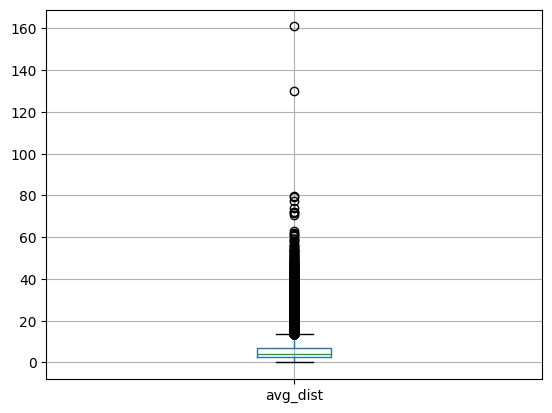

In [109]:
#boxplot of avg_dist
users.boxplot('avg_dist')
plt.show()

#There is one obvious outlier and a long tail on this column. The tailing outliers we'll explore in more detail in EDA

In [110]:
#The 160 value looks to be one user who used their account a single time for a very long trip
#We'll remove this user from the data since their use was very atypical
users[users['avg_dist'] > 150]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
20701,Astapor,0,2014-01-25,NaN,1.0,2014-06-26,Android,0.0,False,100.0,160.96,NaN


In [111]:
users = users[users['avg_dist'] < 150]

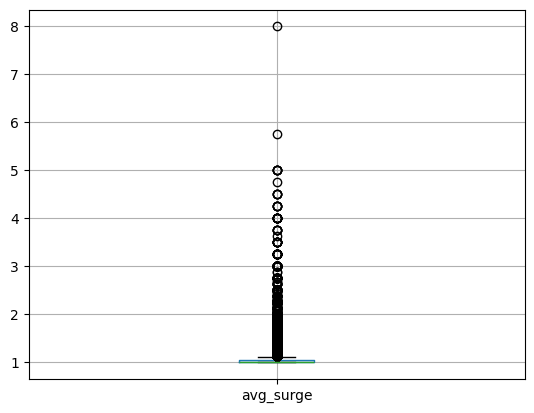

In [112]:
#avg_surge is another feature with a long tail that we'll have to address in more detail during EDA
users.boxplot('avg_surge')
plt.show()

In [113]:
#This looks to be a user who used the app once and got extremely unlucky with the surge pricing
#This isn't an atypical use case and the metrics look correct so we'll leave this record in for now
users[users['avg_surge']==8]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
13861,Winterfell,1,2014-01-01,1.0,8.0,2014-01-01,iPhone,100.0,False,100.0,5.77,5.0


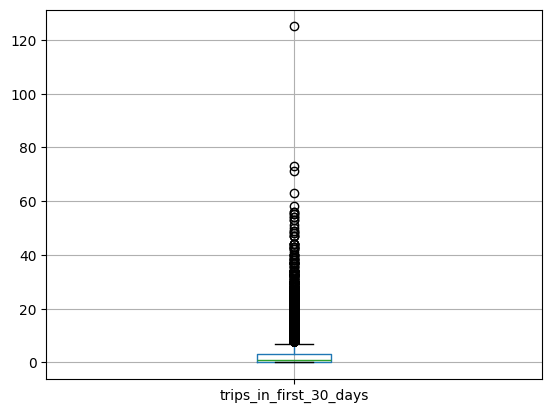

In [114]:
#trips_in_frist_30_days also has a long tail, but there is a very clear anomoly above 120
users.boxplot('trips_in_first_30_days')
plt.show()

In [115]:
#The data on this user looks legitimate, but the 125 trips in one month is an edge case. We'll remove the user
users[users['trips_in_first_30_days']>120]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
18514,King's Landing,125,2014-01-02,5.0,1.12,2014-06-30,iPhone,14.4,True,72.0,2.02,4.8


In [116]:
users = users[users['trips_in_first_30_days']<120]

In [117]:
users.shape

(49998, 12)

**Data Cleaning Summary**

The data was very clean and very few changes were made
*   Null phone types were set to 'unknown'
*   Two users with anomalous behaviour were removed


We have 4,998 records remaining in our data

# **Creating our Outcome Variable**

We are looking to predict rider retention.

**Definition:** we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days

The typical use case for this type of model is to predict churn, so we will make our inidcator 1=churn and 0 = retained

In [118]:
#We don't have a timestamp on our data, so we'll have to estimate this using the latest value in the last_trip_date field
last_day = users['last_trip_date'].max()
print(last_day)

2014-07-01 00:00:00


In [119]:
#30 days preceding our last day
thirty_days_ago = last_day - pd.Timedelta(days=30)
print(thirty_days_ago)

2014-06-01 00:00:00


In [120]:
#Anyone who has a last_trip_date after the thirty_days_ago date is considered 'retained'
users['retained'] = users['last_trip_date'] >= thirty_days_ago

In [121]:
print(users['retained'].value_counts())
print(users['retained'].value_counts(normalize=True))
#Looks like we've retained less than 40%

retained
False    31196
True     18802
Name: count, dtype: int64
retained
False    0.623945
True     0.376055
Name: proportion, dtype: float64


In [122]:
overall_retention = users['retained'].mean()
print(overall_retention)

0.37605504220168806


In [123]:
#Spot check to confirm it looks to be classifying correctly
users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


# **EDA - Categorical**

Findings:
*   city: correlated with retention and should be kept as a feature
*   phone: iPhone and android are correlated with retention and should be kept as features. The 'unknown' category is not significant
*   ultimate_black_user is correlated with retention and shoudl be kept as a feature




In [124]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49998 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49998 non-null  object        
 1   trips_in_first_30_days  49998 non-null  int64         
 2   signup_date             49998 non-null  datetime64[ns]
 3   avg_rating_of_driver    41877 non-null  float64       
 4   avg_surge               49998 non-null  float64       
 5   last_trip_date          49998 non-null  datetime64[ns]
 6   phone                   49998 non-null  object        
 7   surge_pct               49998 non-null  float64       
 8   ultimate_black_user     49998 non-null  bool          
 9   weekday_pct             49998 non-null  float64       
 10  avg_dist                49998 non-null  float64       
 11  avg_rating_by_driver    49798 non-null  float64       
 12  retained                49998 non-null  bool       

**City**

There are three Cities in our dataset: Winterfell, Astapor, and King's Landing.

Approximately 50% of our users signed up in Winterfell, followed by Astapor at ~30% and King's Landing at ~20%.

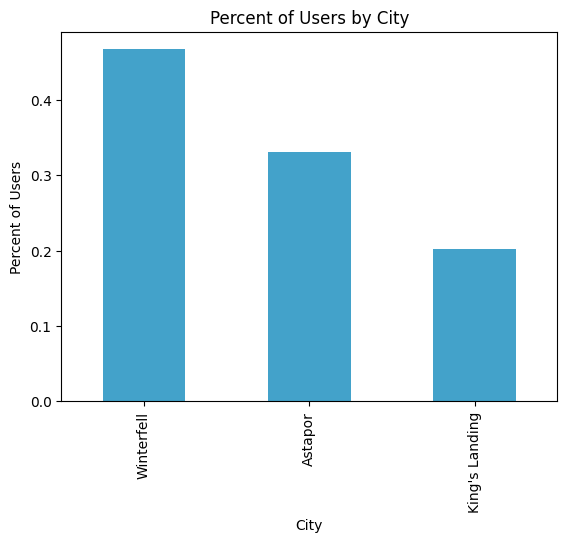

city
Winterfell        0.47
Astapor           0.33
King's Landing    0.20
Name: proportion, dtype: float64


In [125]:
city_counts = users['city'].value_counts(normalize= True)

city_counts.plot(kind='bar', title='Percent of Users by City', color=colour1)
plt.xlabel('City')
plt.ylabel('Percent of Users')
plt.show()

print(round(city_counts,2))

Does City have an impact on retention?

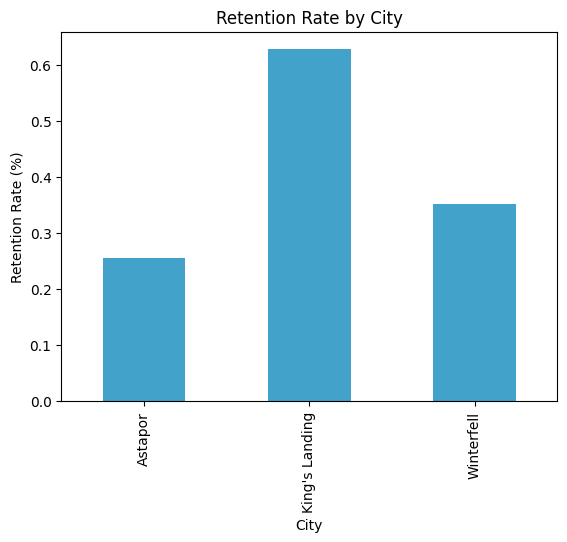

city
Astapor           26.0
King's Landing    63.0
Winterfell        35.0
Name: retained, dtype: float64


In [126]:
city_retention = users.groupby('city')['retained'].mean()

city_retention.plot(kind='bar', title='Retention Rate by City', color=colour1)
plt.xlabel('City')
plt.ylabel('Retention Rate (%)')
plt.show()

print(round(city_retention*100,0))

#Visually it looks like their could be an impact on retention by city. Lets validate

In [127]:
#Testing whether the cities have significantly different retention rates vs the overall average

p_values = {}

# Loop through each unique type
for type in users['city'].unique():
    # Get the retention rates for the current type
    retention_rate = users[users['city'] == type]['retained']

    # The comparison is between the retention rate of the current type and the overall average
    sample_a = retention_rate
    sample_b = np.full(len(sample_a), overall_retention)

    empirical_diff_means = diff_of_means(sample_a, sample_b)
    perm_replicates = draw_perm_reps(sample_a, sample_b, diff_of_means, size=10000)
    p_value = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

    p_values[type] = p_value

for type, p_value in p_values.items():
    print(f'City: {type}, p-value: {round(p_value, 4)}')

#These all have signficant p-values indicating they are correlated with retention

City: King's Landing, p-value: 0.0
City: Astapor, p-value: 0.0
City: Winterfell, p-value: 0.0


**Phone**

There are two phone types: iPhone and Andriod.

~70% of users are have iPhones as their primary devices, while 30% are android

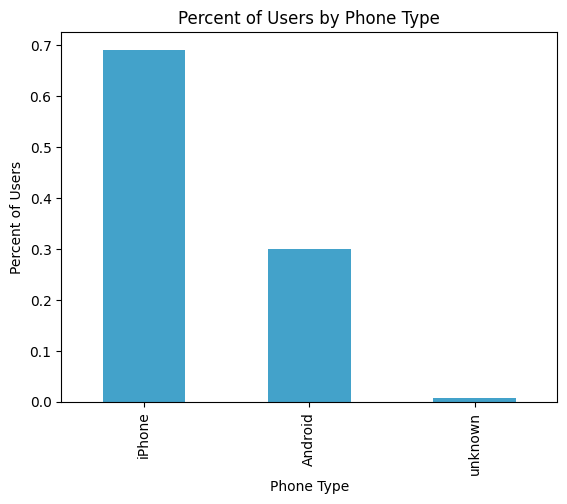

phone
iPhone     0.69
Android    0.30
unknown    0.01
Name: proportion, dtype: float64


In [128]:
phone_counts = users['phone'].value_counts(normalize= True)

phone_counts.plot(kind='bar', title='Percent of Users by Phone Type', color=colour1)
plt.xlabel('Phone Type')
plt.ylabel('Percent of Users')
plt.show()

print(round(phone_counts,2))

Does Phone have an impact on retention?

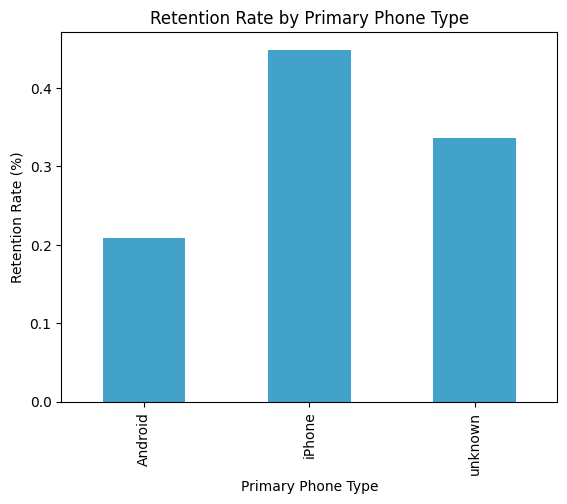

phone
Android    21.0
iPhone     45.0
unknown    34.0
Name: retained, dtype: float64


In [129]:
phone_retention = users.groupby('phone')['retained'].mean()

phone_retention.plot(kind='bar', title='Retention Rate by Primary Phone Type', color=colour1)
plt.xlabel('Primary Phone Type')
plt.ylabel('Retention Rate (%)')
plt.show()

print(round(phone_retention*100,0))

#There definitely looks to be a difference in retention rate by phone type, with android users much more likely to churn

In [130]:
#Testing whether a user's primary phone type has an impact on retention rates vs the overall average

p_values = {}

# Loop through each unique type
for type in users['phone'].unique():
    # Get the retention rates for the current type
    retention_rate = users[users['phone'] == type]['retained']

    # The comparison is between the retention rate of the current type and the overall average
    sample_a = retention_rate
    sample_b = np.full(len(sample_a), overall_retention)

    empirical_diff_means = diff_of_means(sample_a, sample_b)
    perm_replicates = draw_perm_reps(sample_a, sample_b, diff_of_means, size=10000)
    p_value = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

    p_values[type] = p_value

for type, p_value in p_values.items():
    print(f'Phone Type: {type}, p-value: {round(p_value, 4)}')

#iPhone and Android are significant. The 'unknonw' category is not, likely due to the very small sample size.

Phone Type: iPhone, p-value: 0.0
Phone Type: Android, p-value: 0.0
Phone Type: unknown, p-value: 0.0907


**Ultimate Black User**

Only 38% of users used Ultimate Black

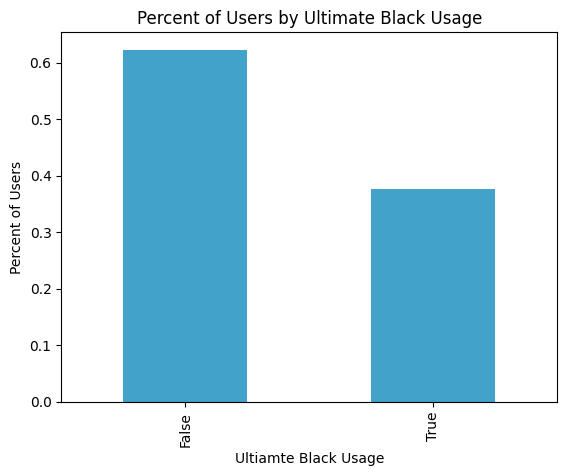

ultimate_black_user
False    0.62
True     0.38
Name: proportion, dtype: float64


In [131]:
ultimateblk_counts = users['ultimate_black_user'].value_counts(normalize= True)

ultimateblk_counts.plot(kind='bar', title='Percent of Users by Ultimate Black Usage', color=colour1)
plt.xlabel('Ultiamte Black Usage')
plt.ylabel('Percent of Users')
plt.show()

print(round(ultimateblk_counts,2))

Did Ultimate Black usage impact retention?

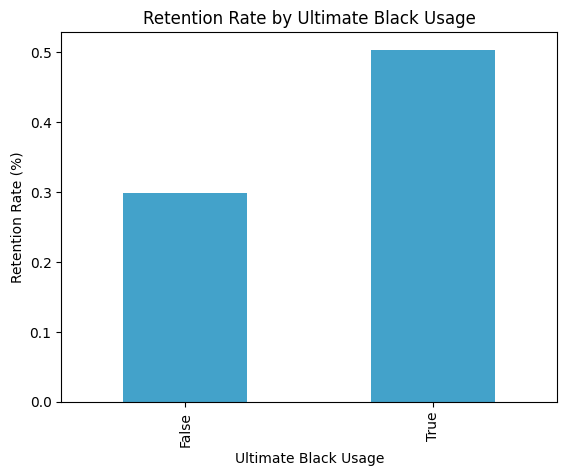

ultimate_black_user
False    30.0
True     50.0
Name: retained, dtype: float64


In [132]:
ultimateblk_retention = users.groupby('ultimate_black_user')['retained'].mean()

ultimateblk_retention.plot(kind='bar', title='Retention Rate by Ultimate Black Usage', color=colour1)
plt.xlabel('Ultimate Black Usage')
plt.ylabel('Retention Rate (%)')
plt.show()

print(round(ultimateblk_retention*100,0))

#There does seem to be a big difference in retention by Ultimate Black usage. Those who used the feature ahev a much higher retention rate

In [133]:
#Testing whether a user's usage of Ultimate Black has an impact on retention rates vs the overall average

p_values = {}

# Loop through each unique type
for type in users['ultimate_black_user'].unique():
    # Get the retention rates for the current type
    retention_rate = users[users['ultimate_black_user'] == type]['retained']

    # The comparison is between the retention rate of the current type and the overall average
    sample_a = retention_rate
    sample_b = np.full(len(sample_a), overall_retention)

    empirical_diff_means = diff_of_means(sample_a, sample_b)
    perm_replicates = draw_perm_reps(sample_a, sample_b, diff_of_means, size=10000)
    p_value = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

    p_values[type] = p_value

for type, p_value in p_values.items():
    print(f'Ultimate Black Usage: {type}, p-value: {round(p_value, 4)}')

#Ultimate Black usage is correlated with retention.

Ultimate Black Usage: True, p-value: 0.0
Ultimate Black Usage: False, p-value: 0.0


# **EDA - Numerical**

All of the below listed fields correlated with retention

Summary of changes made:
*   trips_in_first_30_days has been binned
*   avg_rating_of_driver has been binned
*   avg_surge has been binned
*   surge_pct has been binned
*   weekday_pct has been binned
*   avg_dist has been left as a continuous variable (exponential)
*   avg_rating_by_driver has been binned

Data removed:
*   9 avg_dist outliers were removed from the data










In [134]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49998 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49998 non-null  object        
 1   trips_in_first_30_days  49998 non-null  int64         
 2   signup_date             49998 non-null  datetime64[ns]
 3   avg_rating_of_driver    41877 non-null  float64       
 4   avg_surge               49998 non-null  float64       
 5   last_trip_date          49998 non-null  datetime64[ns]
 6   phone                   49998 non-null  object        
 7   surge_pct               49998 non-null  float64       
 8   ultimate_black_user     49998 non-null  bool          
 9   weekday_pct             49998 non-null  float64       
 10  avg_dist                49998 non-null  float64       
 11  avg_rating_by_driver    49798 non-null  float64       
 12  retained                49998 non-null  bool       

**trips_in_first_30_days**

This column has the number of trips this user took in the first 30 days after signing up

In [135]:
users['trips_in_first_30_days'].describe()

,trips_in_first_30_days
count,49998.000000
mean,2.275791
std,3.752824
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,73.000000


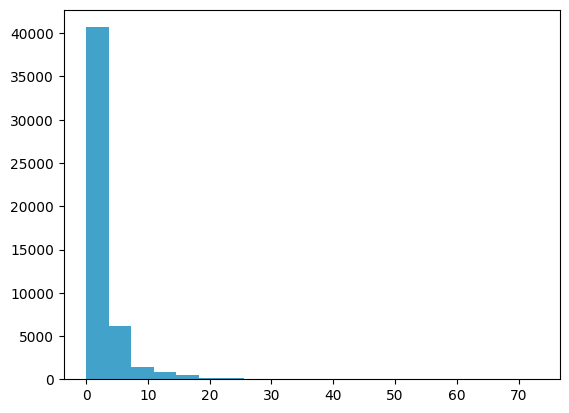

In [136]:
plt.hist(users['trips_in_first_30_days'], bins=20, color=colour1)
plt.show()
#The data is heavily skewed to the left

In [137]:
print('Zeros: ', users[users['trips_in_first_30_days']==0].shape[0])
print('Not Zeros: ', users[users['trips_in_first_30_days']!=0].shape[0])

Zeros:  15389
Not Zeros:  34609


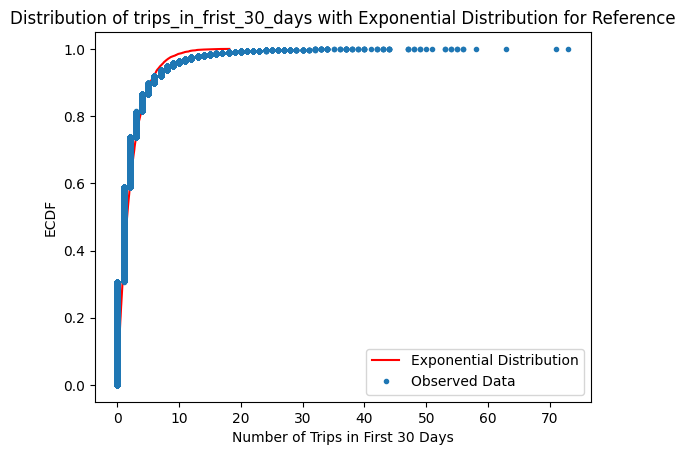

In [138]:
#Comparing the distribution of trips_in_first_30_days to an exponential distribution
rng = np.random.default_rng()

mean = users['trips_in_first_30_days'].mean()
std = users['trips_in_first_30_days'].std()
samples = rng.exponential( scale=mean, size=10000)

#Calculate ECDF
ecdf = ECDF(users['trips_in_first_30_days'])
x, y = ecdf.x, ecdf.y
ecdf_samples = ECDF(samples)
x_theor, y_theor = ecdf_samples.x, ecdf_samples.y

# Plot the ECDFs
_ = plt.plot(x_theor, y_theor, label='Exponential Distribution', color='red')
_ = plt.plot(x, y, marker='.', linestyle='none', label='Observed Data')

_ = plt.xlabel('Number of Trips in First 30 Days')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of trips_in_frist_30_days with Exponential Distribution for Reference')
_ = plt.legend()

plt.show()

#It is very close to an exponential distribution, but it has a longer tail
#The majority of the curve is also represented by just 3 values: 0, 1 and 2
#This would work well bucketed, especailly given the large numebr of 0s

Binning

In [139]:
#Manually assigning bins due to small range
bins = [0,1,2,3,4,5,10,15, np.inf]
labels = ['0', '1', '2', '3', '4', '5-10','10-15' ,'15+']

users['first_30_trips_binned'] = pd.cut(users['trips_in_first_30_days'], bins=bins, labels=labels)

print(users['first_30_trips_binned'].value_counts(dropna=False))

#The nulls will be removed in Feature Engineering when we convert this column to dummies

first_30_trips_binned
NaN      15389
0        14108
1         7402
2         3788
5-10      3362
3         2562
4         1616
10-15      992
15+        779
Name: count, dtype: int64


In [140]:
#We can now drop the trips_in_first_30_days column
users.drop('trips_in_first_30_days', axis=1, inplace=True)

Does the number of trips in the first 30 days impact retention?

<ipython-input-141-a0ebb7e0e778>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  first30_retention = users.groupby('first_30_trips_binned')['retained'].mean()


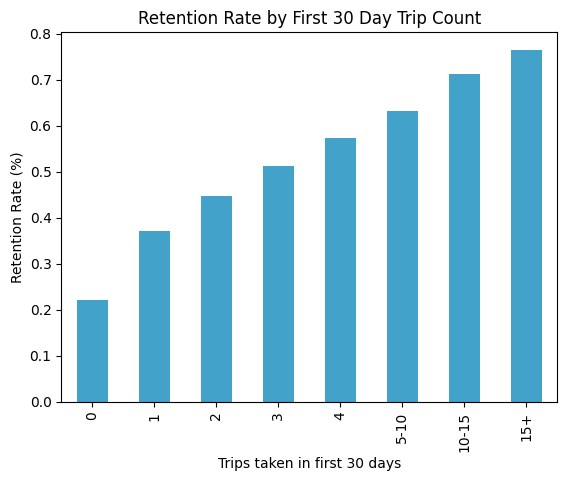

first_30_trips_binned
0        22.0
1        37.0
2        45.0
3        51.0
4        57.0
5-10     63.0
10-15    71.0
15+      77.0
Name: retained, dtype: float64


In [141]:
first30_retention = users.groupby('first_30_trips_binned')['retained'].mean()

first30_retention.plot(kind='bar', title='Retention Rate by First 30 Day Trip Count', color=colour1)
plt.xlabel('Trips taken in first 30 days')
plt.ylabel('Retention Rate (%)')
plt.show()

print(round(first30_retention*100,0))

#This definitely looks like it has an imapct.
#There is a clear increase in retention as the number of trips taken in the first 30 days goes up

**avg_rating_of_driver**

This is the rider’s average rating of their drivers over all of their trips

In [142]:
users['avg_rating_of_driver'].describe()

,avg_rating_of_driver
count,41877.000000
mean,4.601550
std,0.617343
min,1.000000
25%,4.300000
50%,4.900000
75%,5.000000
max,5.000000


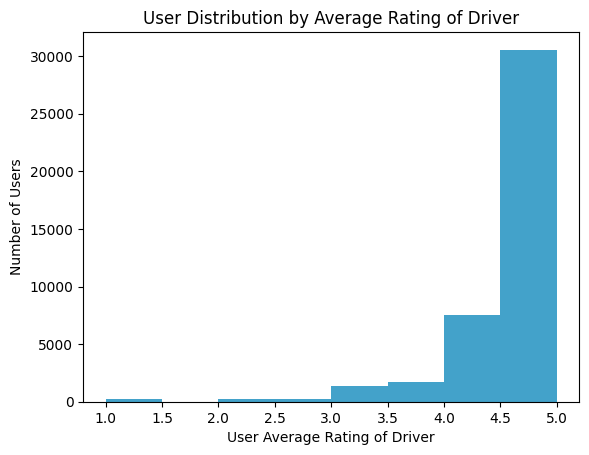

In [143]:
plt.hist(users['avg_rating_of_driver'], bins=8, color=colour1)
plt.title('User Distribution by Average Rating of Driver')
plt.xlabel('User Average Rating of Driver')
plt.ylabel('Number of Users')
plt.show()
#The data is heavily skewed to the right

In [144]:
print('Zeros: ', users[users['avg_rating_of_driver'].isna()].shape[0])
print('Not Zeros: ', users[users['avg_rating_of_driver'].notna()].shape[0])

#8,000 would be a lot of records to remove, so we should should look at binning this value instead of keeping it as a continuous

Zeros:  8121
Not Zeros:  41877


Given the large number of nulls and the highly skewed and limited range, we'll manually bucket this again. Trying to explain this distribution with a log or exponential seems like overkill - the different between a 4.5 and a 5 likely does not need to be picked apart

In [145]:
#Manually assigning bins
bins = [0,3,4,4.5,np.inf]
labels = ['0 - 3', '3 - 4', '4 - 4.5', '4.5 - 5']

users['rating_of_driver_binned'] = pd.cut(users['avg_rating_of_driver'], bins=bins, labels=labels)

print(users['rating_of_driver_binned'].value_counts(dropna=False))

#Nulls will be accounted for in feature engineering when we comvert to dummies

rating_of_driver_binned
4.5 - 5    28059
NaN         8121
3 - 4       6301
4 - 4.5     5813
0 - 3       1704
Name: count, dtype: int64


Does the avg_rating_of_driver impact retention?

<ipython-input-146-69646b50e93f>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_of_driver_retention = users.groupby('rating_of_driver_binned')['retained'].mean()


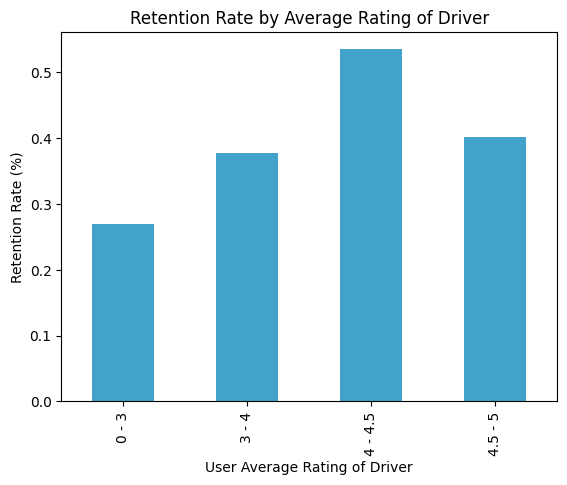

rating_of_driver_binned
0 - 3      27.0
3 - 4      38.0
4 - 4.5    53.0
4.5 - 5    40.0
Name: retained, dtype: float64


In [146]:
rating_of_driver_retention = users.groupby('rating_of_driver_binned')['retained'].mean()

rating_of_driver_retention.plot(kind='bar', title='Retention Rate by Average Rating of Driver', color=colour1)
plt.xlabel('User Average Rating of Driver')
plt.ylabel('Retention Rate (%)')
plt.show()

print(round(rating_of_driver_retention*100,0))

#Interestingly the bin with the highest retnetion rate is 4 to 4.5
#Retention rate increases until 4.5, and then decreases in the 4.5 to 5 bucket

**avg_surge**


The average surge multiplier over all of this user’s trips

In [147]:
users['avg_surge'].describe()

,avg_surge
count,49998.000000
mean,1.074764
std,0.222340
min,1.000000
25%,1.000000
50%,1.000000
75%,1.050000
max,8.000000


In [148]:
print('Zeros: ', users[users['avg_surge'].isna()].shape[0])
print('Not Zeros: ', users[users['avg_surge'].notna()].shape[0])

Zeros:  0
Not Zeros:  49998


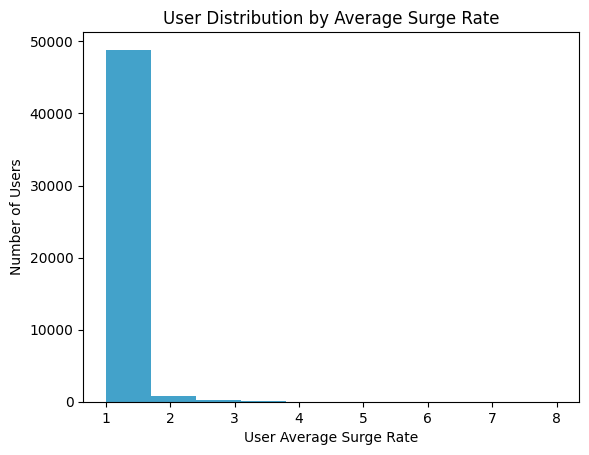

In [149]:
plt.hist(users['avg_surge'], bins=10, color=colour1)
plt.title('User Distribution by Average Surge Rate')
plt.xlabel('User Average Surge Rate')
plt.ylabel('Number of Users')
plt.show()
#The data is HEAVILY skewed to the left, with the majority at 1.0
#We wont be able to describe this distribution with exponential or log

In [150]:
print('Avg of 1: ',np.sum(users['avg_surge']==1))
print('Avg above 1: ',np.sum(users['avg_surge']>1))
print('Avg above 2: ',np.sum(users['avg_surge']>2))

#There actually are a fair number of records above 1
#These are mostly between 1 and 2

Avg of 1:  34453
Avg above 1:  15545
Avg above 2:  467


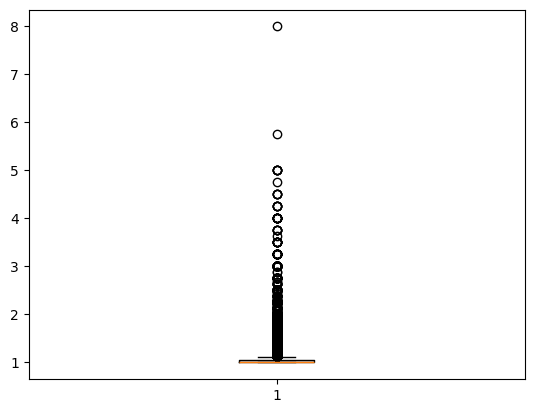

In [151]:
plt.boxplot(users['avg_surge'])
plt.show()

Binning

In [152]:
#Again we're not able to use equal frequency binning since so many records have the same value
bins = [0, 1, 1.1, 1.25, 1.5, 2, np.inf]
labels = ['1.0', '1.0 - 1.1', '1.1 - 1.25', '1.25 - 1.5', '1.5 - 2.0', '2.0+']

users['surge_binned'] = pd.cut(users['avg_surge'], bins=bins, labels=labels)

print(users['surge_binned'].value_counts(dropna=False))

surge_binned
1.0           34453
1.0 - 1.1      6494
1.1 - 1.25     5446
1.25 - 1.5     2067
1.5 - 2.0      1071
2.0+            467
Name: count, dtype: int64


Does average surge have an impact on retention?

<ipython-input-153-aeeeee700fdd>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  surge_retention = users.groupby('surge_binned')['retained'].mean()


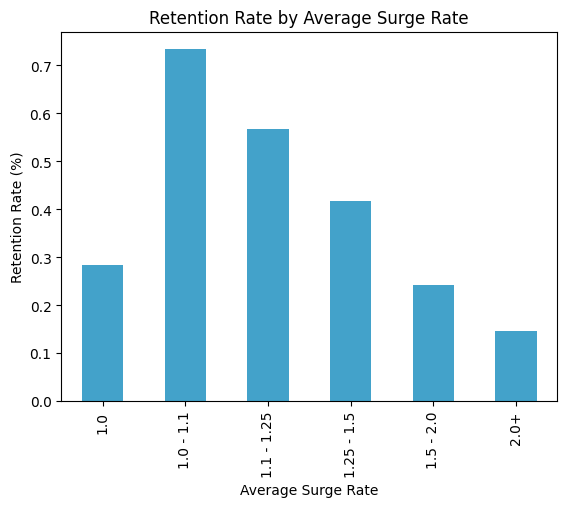

surge_binned
1.0           28.0
1.0 - 1.1     73.0
1.1 - 1.25    57.0
1.25 - 1.5    42.0
1.5 - 2.0     24.0
2.0+          15.0
Name: retained, dtype: float64


In [153]:
surge_retention = users.groupby('surge_binned')['retained'].mean()

surge_retention.plot(kind='bar', title='Retention Rate by Average Surge Rate', color=colour1)
plt.xlabel('Average Surge Rate')
plt.ylabel('Retention Rate (%)')
plt.show()

print(round(surge_retention*100,0))

#Interestingly, avg_surge of one has a pretty low retention rate
#The highest retention rate is in the group that had average surge pricing just above 1. Retention declines from there

**surge_pct**

The percent of trips taken with surge multiplier > 1

In [154]:
users['surge_pct'].describe()

,surge_pct
count,49998.000000
mean,8.849602
std,19.959155
min,0.000000
25%,0.000000
50%,0.000000
75%,8.600000
max,100.000000


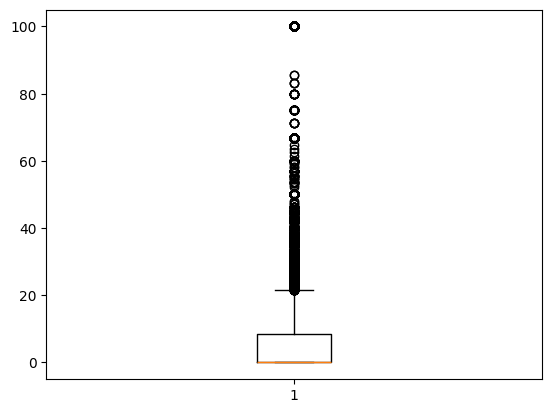

In [155]:
plt.boxplot(users['surge_pct'])
plt.show()

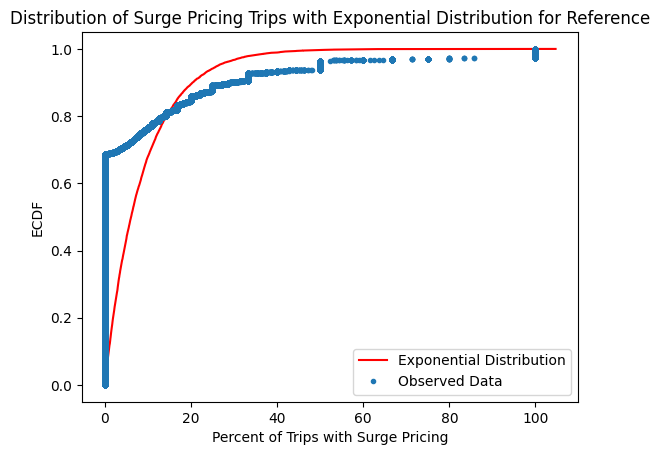

In [156]:
#Comparing the distribution of trips_in_first_30_days to an exponential distribution
rng = np.random.default_rng()

mean = users['surge_pct'].mean()
std = users['surge_pct'].std()
samples = rng.exponential( scale=mean, size=10000)

#Calculate ECDF
ecdf = ECDF(users['surge_pct'])
x, y = ecdf.x, ecdf.y
ecdf_samples = ECDF(samples)
x_theor, y_theor = ecdf_samples.x, ecdf_samples.y

# Plot the ECDFs
_ = plt.plot(x_theor, y_theor, label='Exponential Distribution', color='red')
_ = plt.plot(x, y, marker='.', linestyle='none', label='Observed Data')

_ = plt.xlabel('Percent of Trips with Surge Pricing')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of Surge Pricing Trips with Exponential Distribution for Reference')
_ = plt.legend()

plt.show()

#This is definitely not describable, so once again we will bin

Binning

In [157]:
bins = [-np.inf, 0, 10, 20, 30, 40, 50, np.inf]
labels = ['0', '1 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50+']

users['surge_pct_binned'] = pd.cut(users['surge_pct'], bins=bins, labels=labels)

print(users['surge_pct_binned'].value_counts(dropna=False))

surge_pct_binned
0          34408
10 - 20     4586
1 - 10      3974
20 - 30     2132
50+         1724
30 - 40     1655
40 - 50     1519
Name: count, dtype: int64


Does the percent of rides that were on surge pricing correlate with retention?

<ipython-input-158-5254d360a2f2>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  surge_pct_retention = users.groupby('surge_pct_binned')['retained'].mean()


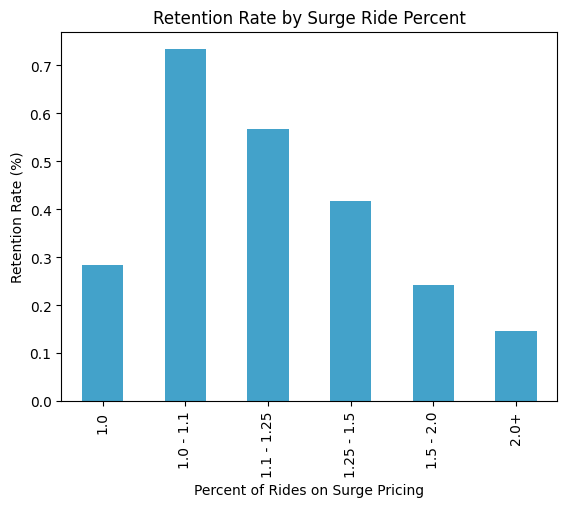

surge_pct_binned
0          28.0
1 - 10     81.0
10 - 20    68.0
20 - 30    61.0
30 - 40    42.0
40 - 50    28.0
50+        19.0
Name: retained, dtype: float64


In [158]:
surge_pct_retention = users.groupby('surge_pct_binned')['retained'].mean()

surge_retention.plot(kind='bar', title='Retention Rate by Surge Ride Percent', color=colour1)
plt.xlabel('Percent of Rides on Surge Pricing')
plt.ylabel('Retention Rate (%)')
plt.show()

print(round(surge_pct_retention*100,0))

#Definitely looks like surge percent has an impact
#Similar results to the avg_surge where the lowest bucket has the lowest retention, but it spikes afterwards

**weekday_pct**

The percent of the user’s trips occurring during a weekday

In [159]:
users['weekday_pct'].describe()

,weekday_pct
count,49998.000000
mean,60.925081
std,37.081800
min,0.000000
25%,33.300000
50%,66.700000
75%,100.000000
max,100.000000


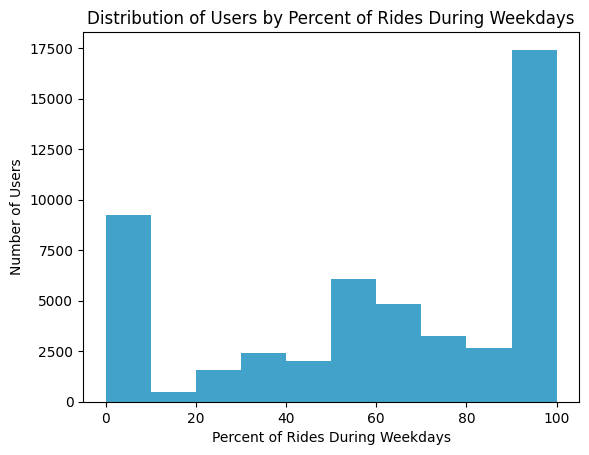

In [160]:
plt.hist(users['weekday_pct'], bins=10, color=colour1)
plt.title('Distribution of Users by Percent of Rides During Weekdays')
plt.xlabel('Percent of Rides During Weekdays')
plt.ylabel('Number of Users')
plt.show()
#This is an interesting distribution. Users are generally skewed far left or far right
#This would indicate that many users use the app for weekdays OR weekends

Binning

In [161]:
bins = [-np.inf, 0, 25, 50, 75, 99, np.inf]
labels = ['0', '1 - 25', '25 - 50', '50 - 75', '75 - 99', '100']

users['weekday_pct_binned'] = pd.cut(users['weekday_pct'], bins=bins, labels=labels)

print(users['weekday_pct_binned'].value_counts(dropna=False))

weekday_pct_binned
100        16658
50 - 75     9324
0           9203
25 - 50     8823
75 - 99     4223
1 - 25      1767
Name: count, dtype: int64


Does weekday_pct correlate wiht retention?

<ipython-input-162-ad62600822b4>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_pct_retention = users.groupby('weekday_pct_binned')['retained'].mean()


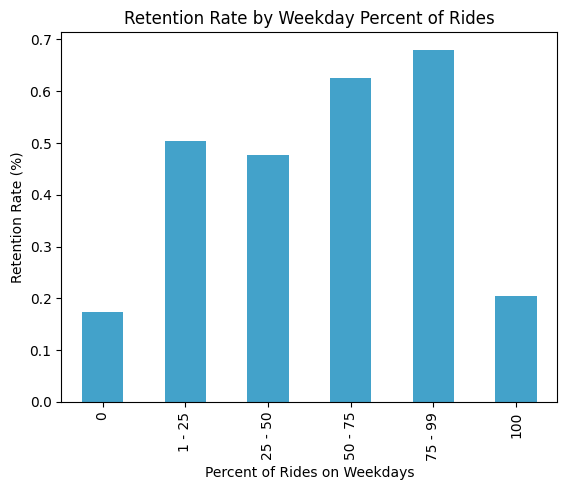

weekday_pct_binned
0          17.0
1 - 25     50.0
25 - 50    48.0
50 - 75    63.0
75 - 99    68.0
100        20.0
Name: retained, dtype: float64


In [162]:
weekday_pct_retention = users.groupby('weekday_pct_binned')['retained'].mean()

weekday_pct_retention.plot(kind='bar', title='Retention Rate by Weekday Percent of Rides', color=colour1)
plt.xlabel('Percent of Rides on Weekdays')
plt.ylabel('Retention Rate (%)')
plt.show()

print(round(weekday_pct_retention*100,0))

#Interestingly, the groups that use the service for only weekday or weekend rides have the lowest retention.
#It looks like we can group our middle bins more

In [163]:
#Adjusting bins
users['weekday_pct_binned'] = users['weekday_pct_binned'].replace({'1 - 25': '1-50', '25 - 50': '1-50'})
users['weekday_pct_binned'] = users['weekday_pct_binned'].replace({'50 - 75': '50-99', '75 - 99': '50-99'})

print(users['weekday_pct_binned'].value_counts(dropna=False))

<ipython-input-163-dc8be3ef0393>:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  users['weekday_pct_binned'] = users['weekday_pct_binned'].replace({'1 - 25': '1-50', '25 - 50': '1-50'})


weekday_pct_binned
100      16658
50-99    13547
1-50     10590
0         9203
Name: count, dtype: int64


<ipython-input-163-dc8be3ef0393>:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  users['weekday_pct_binned'] = users['weekday_pct_binned'].replace({'50 - 75': '50-99', '75 - 99': '50-99'})


**avg_dist**

The average distance in miles per trip taken in the first 30 days after signup

In [164]:
users['avg_dist'].describe()

,avg_dist
count,49998.000000
mean,5.793799
std,5.665103
min,0.000000
25%,2.420000
50%,3.880000
75%,6.940000
max,129.890000


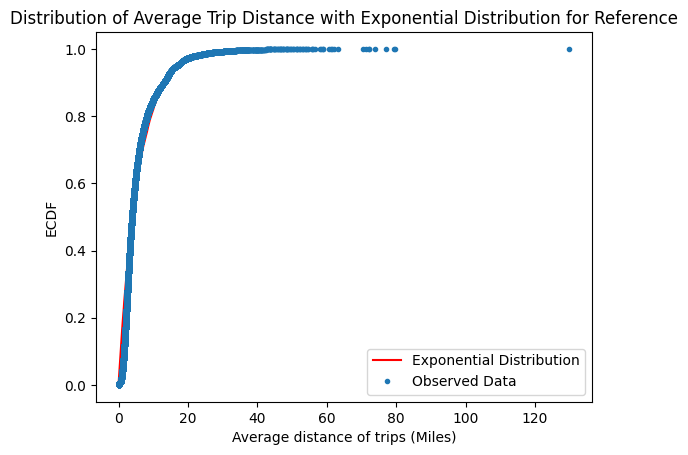

In [165]:
#Comparing the distribution of trips_in_first_30_days to an exponential distribution
rng = np.random.default_rng()

mean = users['avg_dist'].mean()
std = users['avg_dist'].std()
samples = rng.exponential( scale=mean, size=10000)

#Calculate ECDF
ecdf = ECDF(users['avg_dist'])
x, y = ecdf.x, ecdf.y
ecdf_samples = ECDF(samples)
x_theor, y_theor = ecdf_samples.x, ecdf_samples.y

# Plot the ECDFs
_ = plt.plot(x_theor, y_theor, label='Exponential Distribution', color='red')
_ = plt.plot(x, y, marker='.', linestyle='none', label='Observed Data')

_ = plt.xlabel('Average distance of trips (Miles)')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of Average Trip Distance with Exponential Distribution for Reference')
_ = plt.legend()

plt.show()

#An almost perfect match! This field is exponentiallyy distributed
#Out tail is a bit long with some obvious outliers (the group that starts around the 70 mile mark)

Outliers

In [166]:
large_dist_users = users[users['avg_dist']>60]
large_dist_users.sort_values(by='avg_dist', ascending=False)

#Here we can see the group with the larger values starts as of the 70 mile mark

,city,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,first_30_trips_binned,rating_of_driver_binned,surge_binned,surge_pct_binned,weekday_pct_binned
534,King's Landing,2014-01-04,NaN,1.0,2014-03-09,unknown,0.0,False,0.0,129.89,5.0,False,NaN,NaN,1.0,0,0
1302,Winterfell,2014-01-30,5.0,1.0,2014-01-30,iPhone,0.0,False,100.0,79.69,5.0,False,0,4.5 - 5,1.0,0,100
22290,Astapor,2014-01-12,5.0,1.0,2014-06-26,iPhone,0.0,True,100.0,79.34,5.0,True,NaN,4.5 - 5,1.0,0,100
47595,King's Landing,2014-01-25,5.0,1.0,2014-06-09,iPhone,0.0,True,0.0,77.13,5.0,True,NaN,4.5 - 5,1.0,0,0
36625,Astapor,2014-01-19,5.0,1.0,2014-01-22,iPhone,0.0,False,100.0,73.88,3.0,False,1,4.5 - 5,1.0,0,100
22096,Astapor,2014-01-17,NaN,1.0,2014-05-01,iPhone,0.0,True,100.0,72.20,5.0,False,NaN,NaN,1.0,0,100
1493,Astapor,2014-01-26,5.0,1.0,2014-01-27,iPhone,0.0,False,100.0,72.08,5.0,False,0,4.5 - 5,1.0,0,100
19197,Astapor,2014-01-17,4.7,1.0,2014-05-14,iPhone,0.0,True,100.0,71.38,5.0,False,1,4.5 - 5,1.0,0,100
42835,Winterfell,2014-01-10,5.0,1.0,2014-06-28,Android,0.0,False,100.0,70.48,5.0,True,NaN,4.5 - 5,1.0,0,100
18824,Astapor,2014-01-24,NaN,1.0,2014-01-25,Android,0.0,False,100.0,63.15,5.0,False,0,NaN,1.0,0,100


In [167]:
users = users[users['avg_dist']<70]

In [168]:
users.shape

(49989, 17)

**avg_rating_by_driver**

The rider’s average rating over all of their trips

In [169]:
users['avg_rating_by_driver'].describe()

,avg_rating_by_driver
count,49789.000000
mean,4.778158
std,0.446617
min,1.000000
25%,4.700000
50%,5.000000
75%,5.000000
max,5.000000


In [170]:
np.sum(users['avg_rating_by_driver'].isna())

200

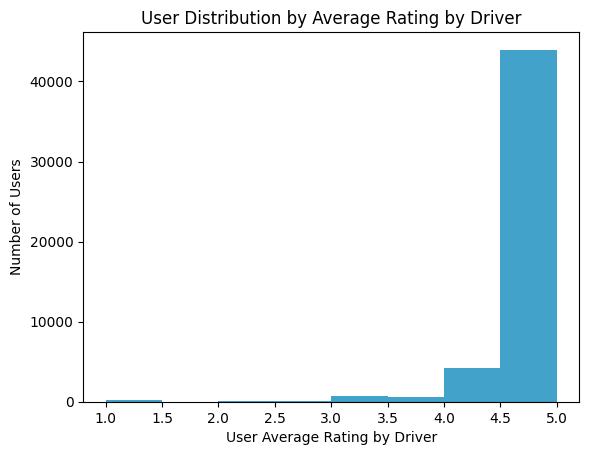

In [171]:
plt.hist(users['avg_rating_by_driver'], bins=8, color=colour1)
plt.title('User Distribution by Average Rating by Driver')
plt.xlabel('User Average Rating by Driver')
plt.ylabel('Number of Users')
plt.show()

#Heavily skewed to the left

In [172]:
print('5.0 Rating: ', np.sum(users['avg_rating_by_driver']==5.0))
print('4.75+ Rating: ', np.sum(users['avg_rating_by_driver']>4.75))
print('4.5+ Rating: ', np.sum(users['avg_rating_by_driver']>4.5))
print('4.0+ Rating: ', np.sum(users['avg_rating_by_driver']>4.0))
#28,500 users have a 5.0 rating

5.0 Rating:  28500
4.75+ Rating:  36130
4.5+ Rating:  41538
4.0+ Rating:  46307


Binning

In [173]:
#Manually assigning bins
bins = [0,4,4.5,4.75,4.99, np.inf]
labels = ['0 - 4.0', '4.0 - 4.5', '4.5 - 4.75', '4.75 - 4.99', '5']

users['rating_by_driver_binned'] = pd.cut(users['avg_rating_by_driver'], bins=bins, labels=labels)

print(users['rating_by_driver_binned'].value_counts(dropna=False))

#The null will be removed when we convert to dummies

rating_by_driver_binned
5              28500
4.75 - 4.99     7630
4.5 - 4.75      5408
4.0 - 4.5       4769
0 - 4.0         3482
NaN              200
Name: count, dtype: int64


# **Feature Engineering**

In [174]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49989 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   city                     49989 non-null  object        
 1   signup_date              49989 non-null  datetime64[ns]
 2   avg_rating_of_driver     41870 non-null  float64       
 3   avg_surge                49989 non-null  float64       
 4   last_trip_date           49989 non-null  datetime64[ns]
 5   phone                    49989 non-null  object        
 6   surge_pct                49989 non-null  float64       
 7   ultimate_black_user      49989 non-null  bool          
 8   weekday_pct              49989 non-null  float64       
 9   avg_dist                 49989 non-null  float64       
 10  avg_rating_by_driver     49789 non-null  float64       
 11  retained                 49989 non-null  bool          
 12  first_30_trips_binned    34605 non-nu

In [175]:
#We can drop the columns that were used to create bins
users.drop(['avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_rating_by_driver'], axis=1, inplace=True)

#We can drop the columns that wont be used in the modelling
users.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)

In [176]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49989 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   city                     49989 non-null  object  
 1   phone                    49989 non-null  object  
 2   ultimate_black_user      49989 non-null  bool    
 3   avg_dist                 49989 non-null  float64 
 4   retained                 49989 non-null  bool    
 5   first_30_trips_binned    34605 non-null  category
 6   rating_of_driver_binned  41870 non-null  category
 7   surge_binned             49989 non-null  category
 8   surge_pct_binned         49989 non-null  category
 9   weekday_pct_binned       49989 non-null  category
 10  rating_by_driver_binned  49789 non-null  category
dtypes: bool(2), category(6), float64(1), object(2)
memory usage: 1.9+ MB


**Categorical Features**

Categorical Features will include everything except retained, avg_dist and ultimate_black_user



In [177]:
users = pd.get_dummies(users, columns=['city'], drop_first=True, prefix='city')

In [178]:
users = pd.get_dummies(users, columns=['phone'], prefix='phone') #We're not goign to drop first here because we want to drop the 'unknown'
users = users.drop(columns=['phone_unknown'])

In [179]:
users = pd.get_dummies(users, columns=['first_30_trips_binned'], drop_first=True, prefix='first30')

In [180]:
users = pd.get_dummies(users, columns=['rating_of_driver_binned'], drop_first=True, prefix='rating_of_driver')

In [181]:
users = pd.get_dummies(users, columns=['rating_by_driver_binned'], drop_first=True, prefix='rating_by_driver')

In [182]:
users = pd.get_dummies(users, columns=['surge_binned'], drop_first=True, prefix='surge_trips')

In [183]:
users = pd.get_dummies(users, columns=['surge_pct_binned'], drop_first=True, prefix='surge_pct')

In [184]:
users = pd.get_dummies(users, columns=['weekday_pct_binned'], drop_first=True, prefix='weekday_pct')

In [185]:
users.info()
#Confirming our categorical columns are good to go
#We have no nulls in the data

<class 'pandas.core.frame.DataFrame'>
Index: 49989 entries, 0 to 49999
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ultimate_black_user           49989 non-null  bool   
 1   avg_dist                      49989 non-null  float64
 2   retained                      49989 non-null  bool   
 3   city_King's Landing           49989 non-null  bool   
 4   city_Winterfell               49989 non-null  bool   
 5   phone_Android                 49989 non-null  bool   
 6   phone_iPhone                  49989 non-null  bool   
 7   first30_1                     49989 non-null  bool   
 8   first30_2                     49989 non-null  bool   
 9   first30_3                     49989 non-null  bool   
 10  first30_4                     49989 non-null  bool   
 11  first30_5-10                  49989 non-null  bool   
 12  first30_10-15                 49989 non-null  bool   
 13  first3

**Train/Test Split**

In [186]:
X = users.drop('retained', axis=1)
y = users['retained']

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)

**Continuous Features**

Preparing the avg_dist column for modelling

In [188]:
users['avg_dist'].describe()

,avg_dist
count,49989.000000
mean,5.780317
std,5.570732
min,0.000000
25%,2.420000
50%,3.880000
75%,6.940000
max,63.150000


In [189]:
#We are going to use a power transformer to scale the feature since it is exponential and does not have bounded ranges
scaler = PowerTransformer(method='yeo-johnson') #Using yeo-johnson since we have 0 distances in our data which box-cox can't process

X_train['avg_dist'] = scaler.fit_transform(X_train[['avg_dist']])
X_test['avg_dist'] = scaler.transform(X_test[['avg_dist']])

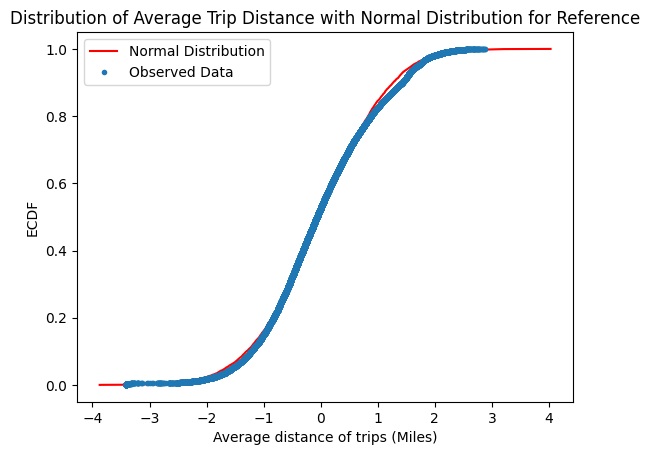

In [190]:
#Viewing the results of our transformation compared to a normal distribution

rng = np.random.default_rng()

mean = X_train['avg_dist'].mean()
std = X_train['avg_dist'].std()
samples = rng.normal(loc=mean, scale=std, size=10000)

#Calculate ECDF
ecdf = ECDF(X_train['avg_dist'])
x, y = ecdf.x, ecdf.y
ecdf_samples = ECDF(samples)
x_theor, y_theor = ecdf_samples.x, ecdf_samples.y

# Plot the ECDFs
_ = plt.plot(x_theor, y_theor, label='Normal Distribution', color='red')
_ = plt.plot(x, y, marker='.', linestyle='none', label='Observed Data')

_ = plt.xlabel('Average distance of trips (Miles)')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of Average Trip Distance with Normal Distribution for Reference')
_ = plt.legend()

plt.show()

#Our transformation worked well! There's only one area with a slight difference from the normal distribution, but it is minor

In [191]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39991 entries, 37158 to 32169
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ultimate_black_user           39991 non-null  bool   
 1   avg_dist                      39991 non-null  float64
 2   city_King's Landing           39991 non-null  bool   
 3   city_Winterfell               39991 non-null  bool   
 4   phone_Android                 39991 non-null  bool   
 5   phone_iPhone                  39991 non-null  bool   
 6   first30_1                     39991 non-null  bool   
 7   first30_2                     39991 non-null  bool   
 8   first30_3                     39991 non-null  bool   
 9   first30_4                     39991 non-null  bool   
 10  first30_5-10                  39991 non-null  bool   
 11  first30_10-15                 39991 non-null  bool   
 12  first30_15+                   39991 non-null  bool   
 13  ra

In [192]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9998 entries, 46974 to 8351
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ultimate_black_user           9998 non-null   bool   
 1   avg_dist                      9998 non-null   float64
 2   city_King's Landing           9998 non-null   bool   
 3   city_Winterfell               9998 non-null   bool   
 4   phone_Android                 9998 non-null   bool   
 5   phone_iPhone                  9998 non-null   bool   
 6   first30_1                     9998 non-null   bool   
 7   first30_2                     9998 non-null   bool   
 8   first30_3                     9998 non-null   bool   
 9   first30_4                     9998 non-null   bool   
 10  first30_5-10                  9998 non-null   bool   
 11  first30_10-15                 9998 non-null   bool   
 12  first30_15+                   9998 non-null   bool   
 13  rati

In [193]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 39991 entries, 37158 to 32169
Series name: retained
Non-Null Count  Dtype
--------------  -----
39991 non-null  bool 
dtypes: bool(1)
memory usage: 351.5 KB


In [194]:
y_test.info()

<class 'pandas.core.series.Series'>
Index: 9998 entries, 46974 to 8351
Series name: retained
Non-Null Count  Dtype
--------------  -----
9998 non-null   bool 
dtypes: bool(1)
memory usage: 87.9 KB


# **Modelling**

The purpose of this model is to predict users that will be retained 6 months from sign-up. We would rather err of the side of caution and minimize the number of false positives predicted by our model (higher precision). We would rather be precise with our retention prediction so that users who might churn are not included in projections and can be identified as candidates for churn prevention interventions.

**Model performance summary:**

*Logistic Regression:* Precision: 0.669 / Recall: 0.760 / Accuracy: 0.768

*Random Forest:* Precision: 0.749 / Recall: 0.605 / Accuracy: 0.775

*Gradient Boosted:* Precision: 0.759 / Recall: 0.54 / Accuracy: 0.762 **Chosen model

*KNN: Precision:* 0.692 / Recall: 0.628 / Accuracy: 0.755

In [195]:
#Confirming our data
print(X_test.shape)
print(y_test.shape)

print(X_train.shape)
print(y_train.shape)

(9998, 34)
(9998,)
(39991, 34)
(39991,)


In [196]:
#Our outcome variable is not a balanced between the 2 classes.
#In our sample, 38% of users were retained

#Given the time contraint placed on this project, we will mostly leverage performance metrics to identify and address issues from this class imbalance
print('Train y balance: ', np.mean(y_train))

Train y balance:  0.37588457402915654


**Logistic Regression**

We'll start with a Logistic Regression model

In [197]:
logreg = LogisticRegression(random_state=38)

param_grid = {
    'C': [0.1, 1.0, 10],
    'penalty': ['l2'], #We've seen that almost all features are significant so we'll start with ls
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'saga'],
    'max_iter': [100, 150, 200],
    'class_weight': ['balanced', None], #
}

grid_search = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

#print("Best parameters:", grid_search.best_params_)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=38), n_jobs=-1,
             param_grid={'C': [0.1, 1.0, 10],
                         'class_weight': ['balanced', None],
                         'max_iter': [100, 150, 200], 'penalty': ['l2'],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs', 'saga']})

In [208]:
#The model would do better with no class weight, but because of our class imbalance lets keep it in for now

logreg = LogisticRegression(C=0.1, max_iter = 100, penalty='l2', solver='newton-cg', class_weight='balanced', random_state=38) #We are adding balanced since it will give our two classes equal weight
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
y_pred_logreg_probs = logreg.predict_proba(X_test)
y_pred_logreg_probs = y_pred_logreg_probs[:,1]

print('Accuracy: ', accuracy_score(y_test, y_pred_logreg))
#The accuracy is ok at 77%

Accuracy:  0.7681536307261452


AUC Score: 0.838882


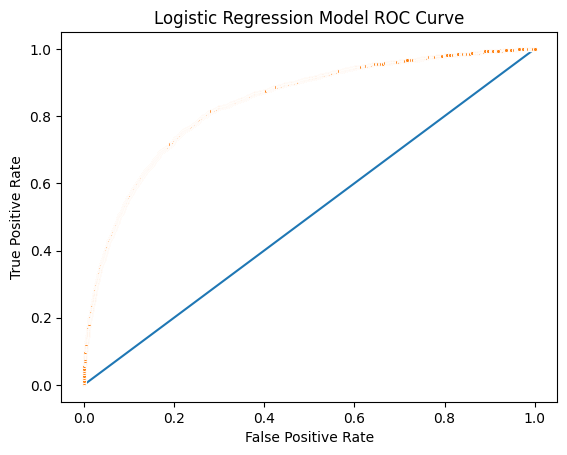

In [199]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_logreg_probs)
sns.lineplot(x=[0,1], y=[0,1], linestyle='-')
ax = sns.lineplot(x=fpr, y=tpr, marker = '.')
ax.set_title('Logistic Regression Model ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

auc_score = roc_auc_score(y_test, y_pred_logreg_probs)
print('AUC Score: %3f' %auc_score)

#With an AUC of 0.84, this model does a good job distiguishing between the positive and negative class

In [200]:
confusion_matrix(y_test, y_pred_logreg)

array([[4815, 1416],
       [ 902, 2865]])

In [220]:
print('Precision: ', precision_score(y_test, y_pred_logreg))
print('Recall: ', recall_score(y_test, y_pred_logreg))

#The recall score is good at 0.76, so the model correctly classified 76% of the actual positives
#The precision score is also fine at 0.76, so the instances that the model predicts to be positive are correct only 70% of the time

Precision:  0.6692361597757533
Recall:  0.7605521635253517


**Random Forest**

In [202]:
rf = RandomForestClassifier(random_state=38)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

#print("Best parameters:", grid_search.best_params_)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=38), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300]})

In [209]:
rf = RandomForestClassifier(criterion = 'entropy', max_depth = 10, n_estimators = 300, random_state=38)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_rf_probs = rf.predict_proba(X_test)
y_pred_rf_probs_pos_class = y_pred_rf_probs[:, 1]

print('Accuracy: ', accuracy_score(y_test, y_pred_rf))

#This gives us an accuracy score of 77% which is the same as our Logistic Regression model

Accuracy:  0.7748549709941989


AUC Score: 0.838041


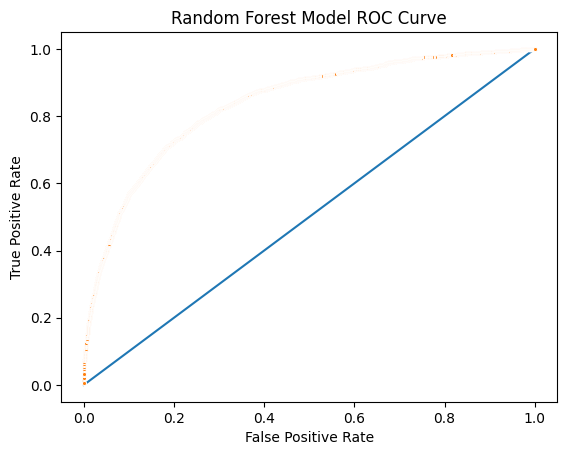

In [210]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf_probs_pos_class)
sns.lineplot(x=[0,1], y=[0,1], linestyle='-')
ax = sns.lineplot(x=fpr, y=tpr, marker = '.')
ax.set_title('Random Forest Model ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

auc_score = roc_auc_score(y_test, y_pred_rf_probs_pos_class)
print('AUC Score: %3f' %auc_score)

#The AUC of 84% is the same as our Logistic Regression model

In [211]:
print('Precision: ', precision_score(y_test, y_pred_rf))
print('Recall: ', recall_score(y_test, y_pred_rf))

#The recall score is not great at 60% identification rate for actual positives
#The precision score is fine at 75% of predicted positives actually being positive

#This model score is not as good as the Logistic Regression model

Precision:  0.7490144546649146
Recall:  0.6052561720201752


Gradient Boosting

In [206]:
def train_GB (est, max_depth, lr):
  gb = GradientBoostingClassifier(n_estimators=est, max_depth=max_depth, learning_rate=lr, random_state=37)
  gb = gb.fit(X_train, y_train)
  y_pred = gb.predict(X_test)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='binary')
  print('Est: {} / Depth: {} / LR: {} --- Precision: {} / Recall: {} / Accuracy: {}'.format(
      est, max_depth, lr, round(precision, 3), round(recall, 3),
      round((y_pred==y_test).sum() / len(y_pred), 3)))

In [207]:
for n_est in [50, 100, 150]:
  for max_depth in [3, 7, 10, 15]:
    for lr in [0.01, 0.1, 1]:
      train_GB(n_est, max_depth, lr)

#There is a very clear trade off between precision and recall in these scores
#Our top options are:
#Balanced
# Est: 150 / Depth: 3 / LR: 0.1 --- Precision: 0.751 / Recall: 0.621 / Accuracy: 0.78 **Our pick
# Est: 50 / Depth: 3 / LR: 1 --- Precision: 0.74 / Recall: 0.633 / Accuracy: 0.778
#Precision Heavy
#Est: 50 / Depth: 7 / LR: 0.01 --- Precision: 0.802 / Recall: 0.426 / Accuracy: 0.744

#Our best precision score gains only 5% while sacrificing close to 20% in recall, so we are going to go with a balanced model
#None of these are great, Logistic Regression is still our best performing model

Est: 50 / Depth: 3 / LR: 0.01 --- Precision: 0.849 / Recall: 0.202 / Accuracy: 0.686
Est: 50 / Depth: 3 / LR: 0.1 --- Precision: 0.753 / Recall: 0.604 / Accuracy: 0.776
Est: 50 / Depth: 3 / LR: 1 --- Precision: 0.74 / Recall: 0.633 / Accuracy: 0.778
Est: 50 / Depth: 7 / LR: 0.01 --- Precision: 0.802 / Recall: 0.426 / Accuracy: 0.744
Est: 50 / Depth: 7 / LR: 0.1 --- Precision: 0.743 / Recall: 0.63 / Accuracy: 0.779
Est: 50 / Depth: 7 / LR: 1 --- Precision: 0.698 / Recall: 0.614 / Accuracy: 0.754
Est: 50 / Depth: 10 / LR: 0.01 --- Precision: 0.798 / Recall: 0.438 / Accuracy: 0.746
Est: 50 / Depth: 10 / LR: 0.1 --- Precision: 0.735 / Recall: 0.625 / Accuracy: 0.774
Est: 50 / Depth: 10 / LR: 1 --- Precision: 0.649 / Recall: 0.615 / Accuracy: 0.73
Est: 50 / Depth: 15 / LR: 0.01 --- Precision: 0.742 / Recall: 0.449 / Accuracy: 0.734
Est: 50 / Depth: 15 / LR: 0.1 --- Precision: 0.7 / Recall: 0.61 / Accuracy: 0.755
Est: 50 / Depth: 15 / LR: 1 --- Precision: 0.635 / Recall: 0.601 / Accuracy: 0.

In [223]:
gb = GradientBoostingClassifier(n_estimators=150, max_depth=3, learning_rate=0.1, random_state=37)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_pred_probs = gb.predict_proba(X_test)
y_pred_probs_pos_class = y_pred_probs[:, 1]

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))

Accuracy:  0.7796559311862372
Precision:  0.7509627727856226
Recall:  0.6211839660207061


**KNN**

In [214]:
#Let's first identify how many neighbors we should use

train_accuracies = {}
test_accuracies = {}

neighbors = np.arange(1,26)
for k in neighbors:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  train_accuracies[k] = knn.score(X_train, y_train)
  test_accuracies[k] = knn.score(X_test, y_test)

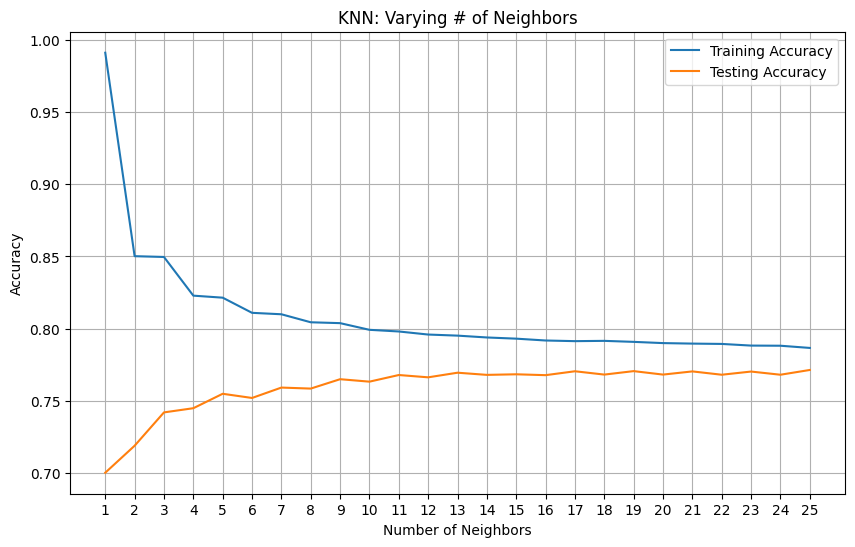

In [215]:
plt.figure(figsize=(10,6))
plt.title('KNN: Varying # of Neighbors')
plt.plot(neighbors, train_accuracies.values(), label='Training Accuracy')
plt.plot(neighbors, test_accuracies.values(), label='Testing Accuracy')

plt.grid(True)
plt.xticks(neighbors)

plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

# There is a big gap between testing and training accuracy
# Let's go with k=5

In [218]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print('Accuracy: ', knn.score(X_test, y_test))
print('Precision: ', precision_score(y_test, y_pred_knn))
print('recall: ', recall_score(y_test, y_pred_knn))

#We're still getting passing but mediocre results
#This model does also does not score as well as our logistic regression model

Score:  0.7548509701940388
Precision:  0.692510239906378
recall:  0.6283514733209451


# **Model Results**

Our Gradient Boosted model is the best performing out of the four model types tested. We prioritized testing model types with explainable results, but given more time we'd try more variations to try and improve model performance.

**Model Performance:**

Our model has a precision score of 0.75, so 75% of the users predicted to be retained were actually retained. The model's recall score is lower at 0.62, so of the actual retained users, 62% are being classified correctly.

These results are mediocre and more model tuning could be used.

**Model Findings**

Users that are most likely to still be active 6 months after sign-up:

*   use the app mainly on weekdays and occasionally on weekends
*   are from Kings Landing
*   primary device is an iPhone


Users that are least likely to be active 6 months after sign-up:

*   use the app only for weekdays OR weekends
*   are not from Kings Landing








**Next Steps**

The Ultimate team can leverage these insights to improve rider retention by:

*   Target marketing towards customer segments/markets more likely to use the service on weekdays (commuters)
*   Review offerings in Kings Landing vs the other cities. What makes this market stand out? Does it have a higher concentration of our target segment, or is there something else going on here and how can we copy it in other cities?





In [224]:
gb = GradientBoostingClassifier(n_estimators=150, max_depth=3, learning_rate=0.1, random_state=37)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_pred_probs = gb.predict_proba(X_test)
y_pred_probs_pos_class = y_pred_probs[:, 1]

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))

Accuracy:  0.7796559311862372
Precision:  0.7509627727856226
Recall:  0.6211839660207061


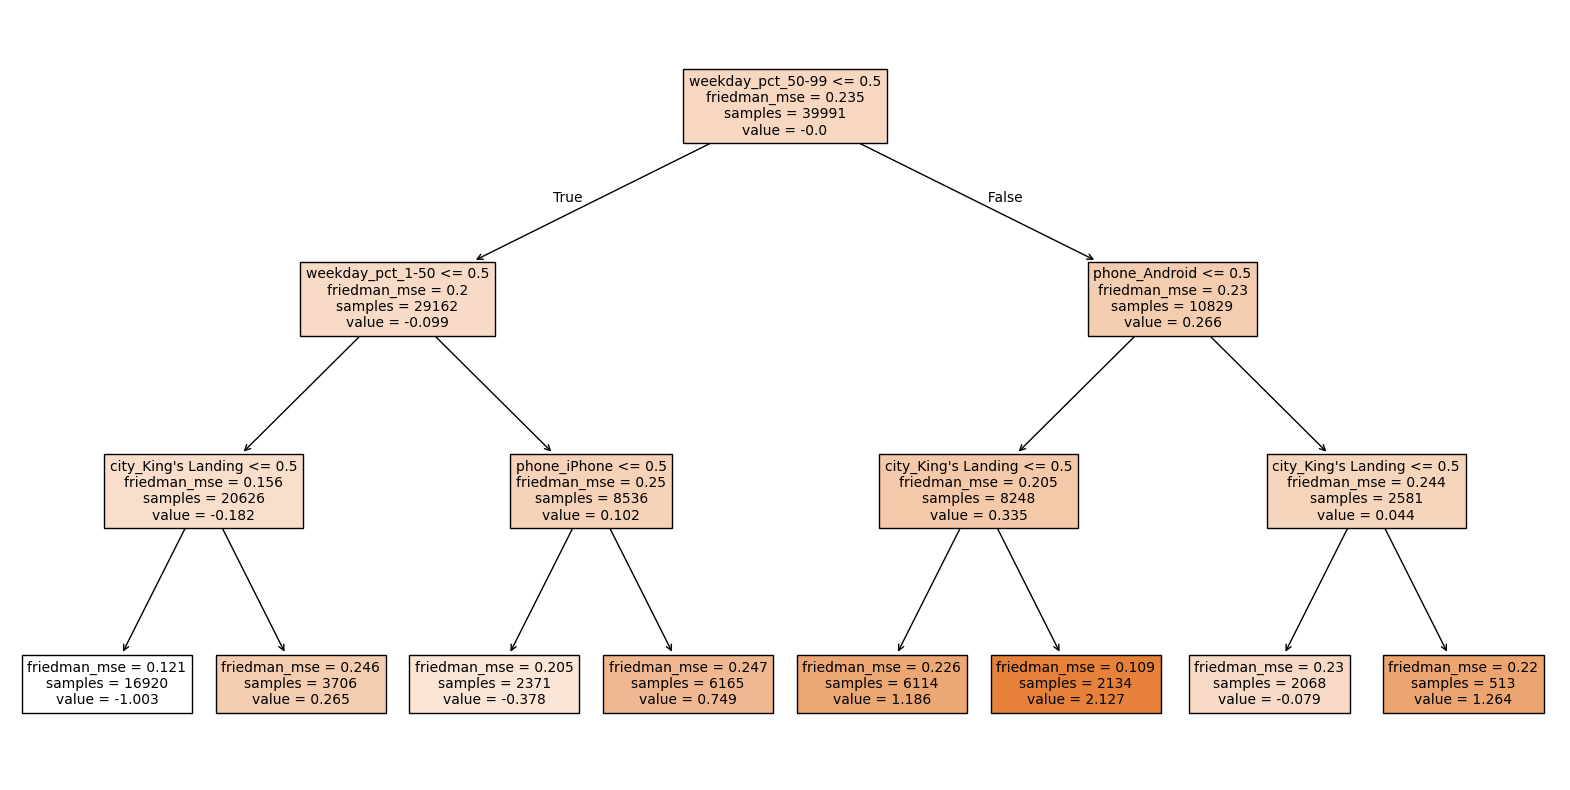

In [227]:
plt.figure(figsize=(20, 10))
plot_tree(gb.estimators_[0, 0], filled=True, feature_names=X_train.columns, fontsize=10)
plt.show()